Optimizing School District Assignments for Fairness, Efficiency, and Compactness

Goal: Optimize Census Blocks Assignement WRT:
- Family Travel Costs: Minimizing the total travel distance for students.
- Racial Balance: Ensuring that the racial composition of each school reflects the overall district composition.
- Compactness: Creating compact school districts to promote community cohesion and reduce administrative complexity.

USE: Envy-Free Approach, Updated Envy-Free and MILP.


**Envy-Cycle Elimination Algorithm (Only Using Distance)**


### Steps:

1. **Initialize:**
    - Start with no items allocated.
    - Agents have valuations over items.
2. **Agents Propose:**
    - Each agent selects their most preferred unallocated item.
3. **Build Envy Graph:**
    - Construct a directed graph where an edge from agent A to agent B exists if A prefers B’s item over their own.
4. **Detect Cycles:**
    - Look for cycles in the envy graph.
    - A cycle represents a group of agents who can exchange allocations to eliminate envy.
5. **Resolve Cycles:**
    - When a cycle is found, allocate the proposed items to the agents in the cycle, breaking the envy.
    - Remove allocated items from the unallocated set.
6. **Repeat:**
    - Continue until all items are allocated or no more proposals can be made.

### Mathematical Formulation:

- **Valuations:** \( v_i(j) \) represents agent \( i \)’s valuation for item \( j \).
- **Allocation:** A mapping \( \pi \) from items to agents.
- **Envy Relation:**
  - Agent \( i \) envies agent \( k \) if \( v_i(\pi(k)) > v_i(\pi(i)) \).
- **Envy Graph:**
  - Nodes represent agents.
  - Directed edges represent envy relations.
- **EEF Property:**
  - Allocation is Envy-Free up to any item if for all agents \( i \) and \( k \), \( v_i(\pi(i)) \geq v_i(\pi(k) \setminus \{g\}) \) for some item \( g \in \pi(k) \).


In [21]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from tqdm import tqdm
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')


solver_time_limit = 60000  # Time limit for the solver in milliseconds (60 sec)
capacity_slack = 1.05      # Slack for capacity constraints - 5% overcapacity allowed

Load and Prepare Schools Data

In [22]:
df_schools = pd.read_csv('Schools_High.csv')

df_schools['geometry'] = df_schools['geom'].apply(wkt.loads)
gdf_schools = gpd.GeoDataFrame(df_schools, geometry='geometry')

gdf_schools.head()

,FID,Name,Address,City,Zipcode,geom,geometry
0,Schools_High.fid--246598da_1926cae7ac2_2fd8,Glenelg,14025 BURNTWOODS RD,Glenelg,21737,POINT (1311661.6690210416 585894.5092805235),POINT (1311661.669 585894.509)
1,Schools_High.fid--246598da_1926cae7ac2_2fd9,Marriotts Ridge,12100 WOODFORD DR,Marriottsville,21104,POINT (1330830.2858533377 602789.1264977695),POINT (1330830.286 602789.126)
2,Schools_High.fid--246598da_1926cae7ac2_2fda,Long Reach,6101 OLD DOBBIN LN,Columbia,21045,POINT (1365779.3478907184 560672.7220443557),POINT (1365779.348 560672.722)
3,Schools_High.fid--246598da_1926cae7ac2_2fdb,Mt. Hebron,9440 OLD FREDERICK RD,Ellicott City,21042,POINT (1357521.8319140594 594493.5641955048),POINT (1357521.832 594493.564)
4,Schools_High.fid--246598da_1926cae7ac2_2fdc,Atholton,6520 FREETOWN RD,Columbia,21044,POINT (1346149.1998624203 554196.6520981742),POINT (1346149.2 554196.652)


Load and Prepare Census Tracts Data

In [23]:
df_tracts = pd.read_csv('Census2020_Tracts.csv')

df_tracts['geometry'] = df_tracts['geom'].apply(wkt.loads)
gdf_tracts = gpd.GeoDataFrame(df_tracts, geometry='geometry')

df_tracts['Tract'] = df_tracts['Tract'].astype(str)

gdf_tracts.head()

,FID,geom,adj_population,Tract,GEOID20,geometry
0,Census2020_Tracts.1,"POLYGON ((1300968 571398, 1300974.7 571393, 13...",4443,604004,24027604004,"POLYGON ((1300968 571398, 1300974.7 571393, 13..."
1,Census2020_Tracts.2,"POLYGON ((1282600.7 586341.4, 1282499.7 586284...",4113,604003,24027604003,"POLYGON ((1282600.7 586341.4, 1282499.7 586284..."
2,Census2020_Tracts.3,"POLYGON ((1276815 591119.7, 1276748.6 591003.3...",6458,604001,24027604001,"POLYGON ((1276815 591119.7, 1276748.6 591003.3..."
3,Census2020_Tracts.4,"POLYGON ((1387063.9 551132.8, 1386989.9 551114...",7752,601204,24027601204,"POLYGON ((1387063.9 551132.8, 1386989.9 551114..."
4,Census2020_Tracts.5,"POLYGON ((1316243.3 581725.2, 1315987.8 581674...",4607,603003,24027603003,"POLYGON ((1316243.3 581725.2, 1315987.8 581674..."


Load and Prepare Race Data

In [24]:
df_race = pd.read_csv('RaceByCounty.csv')

df_race.columns = df_race.iloc[0]  # Set the first row as header
df_race = df_race[1:]              # Remove the header row from data
df_race['Tract'] = df_race['Geography'].apply(lambda x: x[-11:])
df_race['Tract'] = df_race['Tract'].astype(str)

df_blocks = pd.merge(df_tracts, df_race, on='Tract', how='left')

df_blocks.head()

,FID,geom,adj_population,Tract,GEOID20,geometry,Geography,Geographic Area Name,!!Total:,!!Total:!!Owner occupied:,...,!!Total:!!Owner occupied:!!Householder who is Two or More Races,!!Total:!!Renter occupied:,!!Total:!!Renter occupied:!!Householder who is White alone,!!Total:!!Renter occupied:!!Householder who is Black or African American alone,!!Total:!!Renter occupied:!!Householder who is American Indian and Alaska Native alone,!!Total:!!Renter occupied:!!Householder who is Asian alone,!!Total:!!Renter occupied:!!Householder who is Native Hawaiian and Other Pacific Islander alone,!!Total:!!Renter occupied:!!Householder who is Some Other Race alone,!!Total:!!Renter occupied:!!Householder who is Two or More Races,NaN
0,Census2020_Tracts.1,"POLYGON ((1300968 571398, 1300974.7 571393, 13...",4443,604004,24027604004,"POLYGON ((1300968 571398, 1300974.7 571393, 13...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Census2020_Tracts.2,"POLYGON ((1282600.7 586341.4, 1282499.7 586284...",4113,604003,24027604003,"POLYGON ((1282600.7 586341.4, 1282499.7 586284...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Census2020_Tracts.3,"POLYGON ((1276815 591119.7, 1276748.6 591003.3...",6458,604001,24027604001,"POLYGON ((1276815 591119.7, 1276748.6 591003.3...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Census2020_Tracts.4,"POLYGON ((1387063.9 551132.8, 1386989.9 551114...",7752,601204,24027601204,"POLYGON ((1387063.9 551132.8, 1386989.9 551114...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Census2020_Tracts.5,"POLYGON ((1316243.3 581725.2, 1315987.8 581674...",4607,603003,24027603003,"POLYGON ((1316243.3 581725.2, 1315987.8 581674...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wrangle Population and Race Data

In [25]:
df_blocks['adj_population'] = pd.to_numeric(df_blocks['adj_population'], errors='coerce').fillna(0)
df_blocks['Population'] = df_blocks['adj_population']

df_blocks['Population'] = df_blocks['Population'].apply(lambda x: max(x, 1e-6))

race_columns = [
    ' !!Total:!!Owner occupied:!!Householder who is White alone',
    ' !!Total:!!Owner occupied:!!Householder who is Black or African American alone',
    ' !!Total:!!Owner occupied:!!Householder who is Asian alone',
    ' !!Total:!!Renter occupied:!!Householder who is White alone',
    ' !!Total:!!Renter occupied:!!Householder who is Black or African American alone',
    ' !!Total:!!Renter occupied:!!Householder who is Asian alone'
]

for col in race_columns:
    df_blocks[col] = pd.to_numeric(df_blocks[col], errors='coerce').fillna(0)

df_blocks['White'] = (
    df_blocks[' !!Total:!!Owner occupied:!!Householder who is White alone'] +
    df_blocks[' !!Total:!!Renter occupied:!!Householder who is White alone']
)
df_blocks['Black'] = (
    df_blocks[' !!Total:!!Owner occupied:!!Householder who is Black or African American alone'] +
    df_blocks[' !!Total:!!Renter occupied:!!Householder who is Black or African American alone']
)
df_blocks['Asian'] = (
    df_blocks[' !!Total:!!Owner occupied:!!Householder who is Asian alone'] +
    df_blocks[' !!Total:!!Renter occupied:!!Householder who is Asian alone']
)

for race in ['White', 'Black', 'Asian']:
    df_blocks[race] = df_blocks[race].apply(lambda x: max(x, 1e-6))

df_blocks.head()

,FID,geom,adj_population,Tract,GEOID20,geometry,Geography,Geographic Area Name,!!Total:,!!Total:!!Owner occupied:,...,!!Total:!!Renter occupied:!!Householder who is American Indian and Alaska Native alone,!!Total:!!Renter occupied:!!Householder who is Asian alone,!!Total:!!Renter occupied:!!Householder who is Native Hawaiian and Other Pacific Islander alone,!!Total:!!Renter occupied:!!Householder who is Some Other Race alone,!!Total:!!Renter occupied:!!Householder who is Two or More Races,NaN,Population,White,Black,Asian
0,Census2020_Tracts.1,"POLYGON ((1300968 571398, 1300974.7 571393, 13...",4443,604004,24027604004,"POLYGON ((1300968 571398, 1300974.7 571393, 13...",NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,4443,0.000001,0.000001,0.000001
1,Census2020_Tracts.2,"POLYGON ((1282600.7 586341.4, 1282499.7 586284...",4113,604003,24027604003,"POLYGON ((1282600.7 586341.4, 1282499.7 586284...",NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,4113,0.000001,0.000001,0.000001
2,Census2020_Tracts.3,"POLYGON ((1276815 591119.7, 1276748.6 591003.3...",6458,604001,24027604001,"POLYGON ((1276815 591119.7, 1276748.6 591003.3...",NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,6458,0.000001,0.000001,0.000001
3,Census2020_Tracts.4,"POLYGON ((1387063.9 551132.8, 1386989.9 551114...",7752,601204,24027601204,"POLYGON ((1387063.9 551132.8, 1386989.9 551114...",NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,7752,0.000001,0.000001,0.000001
4,Census2020_Tracts.5,"POLYGON ((1316243.3 581725.2, 1315987.8 581674...",4607,603003,24027603003,"POLYGON ((1316243.3 581725.2, 1315987.8 581674...",NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,4607,0.000001,0.000001,0.000001


Calculate Overall Racial Proportions

In [26]:
total_white = df_blocks['White'].sum()
total_black = df_blocks['Black'].sum()
total_asian = df_blocks['Asian'].sum()
total_race_population = total_white + total_black + total_asian

if total_race_population == 0:
    total_race_population = 1e-6

P_k = {
    'White': total_white / total_race_population,
    'Black': total_black / total_race_population,
    'Asian': total_asian / total_race_population
}

print("Overall Racial Proportions:")
for race, proportion in P_k.items():
    print(f"{race}: {proportion:.4f}")

Overall Racial Proportions:
White: 0.3333
Black: 0.3333
Asian: 0.3333


Centroids and Distance Matrix

In [27]:
# Compute centroids of tracts for distance calculation
gdf_blocks = gpd.GeoDataFrame(df_blocks, geometry='geometry')
gdf_blocks['centroid'] = gdf_blocks['geometry'].centroid

# Make distance matrix between blocks and schools
dist = {}
max_distance = 0  # To calculate Big M for compactness constraints
for idx_block, block in tqdm(gdf_blocks.iterrows(), total=gdf_blocks.shape[0], desc='Calculating distances'):
    block_name = block['Tract']
    dist[block_name] = {}
    block_centroid = block['centroid']
    for idx_school, school in gdf_schools.iterrows():
        school_name = school['Name']
        school_point = school['geometry']
        distance = block_centroid.distance(school_point)
        dist[block_name][school_name] = distance
        if distance > max_distance:
            max_distance = distance

# Set Big M for compactness constraints
BigM = max_distance + 1

Calculating distances: 100%|██████████| 59/59 [00:00<00:00, 3620.06it/s]


In [28]:
epsilon = 1e-6
max_distance = max([max(dist_row.values()) for dist_row in dist.values()])

school_names = list(gdf_schools['Name'])
block_names = list(gdf_blocks['Tract'])

valuations = {}
for school in school_names:
    valuations[school] = {}
    for block in block_names:
        distance = dist[block][school]
        valuations[school][block] = max_distance - distance + epsilon  # Avoid zero valuations

In [29]:
print("\nSample Valuations:")
for school in school_names[:1]:  # Just printing for one school as an example
	print(f"\nValuations for {school}:")
	for block in list(valuations[school].keys())[:5]:
		print(f"  Block {block}: {valuations[school][block]:.4f}")


Sample Valuations:

Valuations for Glenelg:
  Block 604004: 80414.5809
  Block 604003: 76896.0047
  Block 604001: 59230.0258
  Block 601204: 15347.2083
  Block 603003: 74776.7755


## Envy-Free Approach

In [30]:
from collections import defaultdict, deque

def eefx_allocation(valuations, capacity_per_school):
    # Initialize allocation and unallocated items
    allocation = {school: [] for school in school_names}
    unallocated_blocks = set(block_names)

    # Initialize capacities
    remaining_capacity = {school: capacity_per_school for school in school_names}

    # While there are unallocated blocks
    while unallocated_blocks:
        # Each school selects its most valued unallocated block
        proposals = {}
        proposed_blocks = set()
        for school in school_names:
            if remaining_capacity[school] > 0:
                # Get the unallocated blocks sorted by valuation
                preferred_blocks = sorted(
                    unallocated_blocks,
                    key=lambda block: -valuations[school][block]
                )
                # Find a block that fits in the remaining capacity and hasn't been proposed yet
                for block in preferred_blocks:
                    if block in proposed_blocks:
                        continue  # Skip if block is already proposed
                    block_population = df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0]
                    if remaining_capacity[school] - block_population >= 0:
                        proposals[school] = block
                        proposed_blocks.add(block)
                        break

        # If no proposals, break
        if not proposals:
            break

        # Build envy graph
        envy_graph = defaultdict(list)
        for school_i in proposals:
            for school_j in proposals:
                if school_i != school_j:
                    # If school_i values school_j's proposed block more than its own
                    if valuations[school_i][proposals[school_j]] > valuations[school_i][proposals[school_i]]:
                        envy_graph[school_i].append(school_j)

        # Detect cycles in envy graph
        def find_cycle():
            visited = set()
            stack = []

            def dfs(school):
                if school in stack:
                    return stack[stack.index(school):]
                if school in visited:
                    return None
                visited.add(school)
                stack.append(school)
                for neighbor in envy_graph[school]:
                    cycle = dfs(neighbor)
                    if cycle:
                        return cycle
                stack.pop()
                return None

            for school in proposals:
                cycle = dfs(school)
                if cycle:
                    return cycle
            return None

        cycle = find_cycle()
        if cycle:
            # Allocate blocks along the cycle
            for school in cycle:
                block = proposals[school]
                allocation[school].append(block)
                unallocated_blocks.remove(block)
                block_population = df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0]
                remaining_capacity[school] -= block_population
        else:
            # Allocate proposed blocks
            for school, block in proposals.items():
                allocation[school].append(block)
                unallocated_blocks.remove(block)
                block_population = df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0]
                remaining_capacity[school] -= block_population

    return allocation

In [31]:
# Run EEFX Algorithm
total_population = df_blocks['Population'].sum()
num_schools = len(school_names)
capacity_per_school = capacity_slack * (total_population / num_schools)
eefx_alloc = eefx_allocation(valuations, capacity_per_school)

eefx_assignments = []
for school, blocks in eefx_alloc.items():
    for block in blocks:
        eefx_assignments.append({'Tract': block, 'School': school})

df_eefx_assignments = pd.DataFrame(eefx_assignments)

df_eefx_results = pd.merge(df_eefx_assignments, df_blocks, on='Tract', how='left')

In [32]:
def compute_metrics(df_results):
    # Calculate total family cost
    family_cost = 0
    for idx, row in df_results.iterrows():
        block = row['Tract']
        school = row['School']
        distance = dist[block][school]
        population = row['Population']
        family_cost += population * distance

    # Calculate racial imbalance
    racial_imbalance = 0
    for school in school_names:
        school_data = df_results[df_results['School'] == school]
        n_j = school_data['Population'].sum()
        racial_imbalance_school = 0
        for race in ['White', 'Black', 'Asian']:
            n_jk = school_data[race].sum()
            expected = P_k[race] * n_j
            racial_imbalance_school += abs(n_jk - expected)
        racial_imbalance += racial_imbalance_school

    # Calculate compactness penalty (max distance to assigned blocks)
    compactness_penalty = 0
    for school in school_names:
        school_data = df_results[df_results['School'] == school]
        if school_data.empty:
            continue
        max_distance = school_data.apply(lambda row: dist[row['Tract']][school], axis=1).max()
        compactness_penalty += max_distance

    # Calculate entropy
    school_entropies = {}
    for school in school_names:
        school_data = df_results[df_results['School'] == school]
        total_population = school_data['Population'].sum()
        white_population = school_data['White'].sum()
        black_population = school_data['Black'].sum()
        asian_population = school_data['Asian'].sum()
        total_race_population = white_population + black_population + asian_population
        if total_race_population == 0:
            continue
        proportions = {
            'White': white_population / total_race_population,
            'Black': black_population / total_race_population,
            'Asian': asian_population / total_race_population
        }
        entropy = -sum([p * np.log(p) if p > 0 else 0 for p in proportions.values()])
        school_entropies[school] = entropy

    average_entropy = np.mean(list(school_entropies.values()))

    # Compute envy count
    envy_count = 0
    for idx, row in df_results.iterrows():
        block = row['Tract']
        assigned_school = row['School']
        assigned_distance = dist[block][assigned_school]
        for school in school_names:
            if school != assigned_school:
                other_distance = dist[block][school]
                if other_distance + 1e-6 < assigned_distance:
                    envy_count += 1
                    break  # Count each block only once

    return {
        'family_cost': family_cost,
        'racial_imbalance': racial_imbalance,
        'compactness_penalty': compactness_penalty,
        'average_entropy': average_entropy,
        'envy_count': envy_count
    }
    
eefx_metrics = compute_metrics(df_eefx_results)


In [33]:
print("\nEEF Allocation Metrics:")
print(f"Total Family Cost: {eefx_metrics['family_cost']}")
print(f"Total Racial Imbalance: {eefx_metrics['racial_imbalance']}")
print(f"Total Compactness Penalty: {eefx_metrics['compactness_penalty']}")
print(f"Average Entropy (Theil Index): {eefx_metrics['average_entropy']}")
print(f"Total Envy Count: {eefx_metrics['envy_count']}")


EEF Allocation Metrics:
Total Family Cost: 4826736917.828575
Total Racial Imbalance: 323245.99982599996
Total Compactness Penalty: 422758.122618798
Average Entropy (Theil Index): 1.0986122886681093
Total Envy Count: 20


## Revised Envy Algorithm with Multiple Factors

In the revised algorithm, we adjust the valuations to include multiple factors. The steps remain similar, but the envy graph and proposals now reflect the composite valuations.

### Adjusted Steps:

1. **Initialize:**
    - Agents have composite valuations over items.
2. **Agents Propose:**
    - Each agent selects the unallocated item with the highest composite valuation.
3. **Build Envy Graph:**
    - Construct the envy graph based on the composite valuations.
4. **Detect Cycles and Resolve:**
    - Same as before, but now envy is based on multiple factors.
5. **Capacity Constraints:**
    - Before accepting a proposal, check if assigning the item exceeds the agent’s capacity.
    - If capacity is exceeded, adjust valuations or skip the item.
6. **Repeat:**
    - Continue until no more allocations can be made.

### Mathematical Adjustments:

- **Composite Valuations:** $V_i(j)$ includes multiple factors.
- **Envy Relation:**
  - Agent $i$ envies agent $k$ if $V_i(\pi(k)) > $V_i(\pi(i))$.
- **Capacity Constraints:**
  - Ensure $\sum_{j \in \pi(i)} n_j \leq \text{Capacity}_i$, where $n_j$ is the population of item $j$.
  
### Mathematical Properties
- **EEFX Property:**
  - Allocation is Envy-Free up to any item and any factor.
  - For all agents $i$ and $k$, $V_i(\pi(i)) \geq V_i(\pi(k) \setminus \{g\})$ for some item $g \in \pi(k)$ (i.e. Ensures that no school  $s_i$ envies another school  $s_j$’s allocation after removing any single block from  $s_j$ ’s allocation)

In [34]:
def compute_composite_valuations(allocation, remaining_capacity, unallocated_blocks):
    valuations = {}
    for school in school_names:
        valuations[school] = {}
        # Get current school allocation
        school_blocks = allocation[school]
        school_data = df_blocks[df_blocks['Tract'].isin(school_blocks)]
        n_s = school_data['Population'].sum()
        n_s_k = {race: school_data[race].sum() for race in ['White', 'Black', 'Asian']}
        for block in unallocated_blocks:
            # Distance valuation
            distance = dist[block][school]
            V_distance = (max_distance - distance) / max_distance

            # Racial balance valuation
            n_b = df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0]
            n_b_k = {race: df_blocks.loc[df_blocks['Tract'] == block, race].values[0] for race in ['White', 'Black', 'Asian']}
            n_total = n_s + n_b
            racial_imbalance_before = sum([abs((n_s_k[race]/n_s if n_s > 0 else 0) - P_k[race]) for race in ['White', 'Black', 'Asian']])
            n_s_k_new = {race: n_s_k[race] + n_b_k[race] for race in ['White', 'Black', 'Asian']}
            racial_imbalance_after = sum([abs((n_s_k_new[race]/n_total if n_total > 0 else 0) - P_k[race]) for race in ['White', 'Black', 'Asian']])
            V_racial = - (racial_imbalance_after) / (3 * max_possible_imbalance)  # Divided by 3 since there are 3 races

            # Capacity impact valuation
            remaining_cap = remaining_capacity[school]
            V_capacity = 1 if remaining_cap >= n_b else 0  # 1 if within capacity, 0 otherwise

            # Composite valuation
            valuations[school][block] = (lambda_distance * V_distance +
                                         lambda_racial * V_racial +
                                         lambda_capacity * V_capacity)
    return valuations

In [35]:
def eefx_allocation_composite(remaining_capacity):
    """
    Compute EEFX allocation using composite valuations.

    Args:
        remaining_capacity: Remaining capacity per school.

    Returns:
        Final allocation: A dictionary {agent (school): [allocated_items (blocks)]}
    """
    # Initialize allocation and unallocated items
    allocation = {school: [] for school in school_names}
    unallocated_blocks = set(block_names)

    # While there are unallocated blocks
    while unallocated_blocks:
        # Compute composite valuations
        valuations = compute_composite_valuations(allocation, remaining_capacity, unallocated_blocks)

        # Each school selects its most valued unallocated block
        proposals = {}
        proposed_blocks = set()
        for school in school_names:
            if remaining_capacity[school] > 0:
                # Get the unallocated blocks sorted by valuation
                preferred_blocks = sorted(
                    unallocated_blocks,
                    key=lambda block: -valuations[school][block]
                )
                # Find a block that fits in the remaining capacity and hasn't been proposed yet
                for block in preferred_blocks:
                    if block in proposed_blocks:
                        continue  # Skip if block is already proposed
                    block_population = df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0]
                    if remaining_capacity[school] - block_population >= 0:
                        proposals[school] = block
                        proposed_blocks.add(block)
                        break

        # If no proposals, break
        if not proposals:
            break

        # Build envy graph
        envy_graph = defaultdict(list)
        for school_i in proposals:
            for school_j in proposals:
                if school_i != school_j:
                    # If school_i values school_j's proposed block more than its own
                    if valuations[school_i][proposals[school_j]] > valuations[school_i][proposals[school_i]]:
                        envy_graph[school_i].append(school_j)

        # Detect cycles in envy graph
        def find_cycle():
            visited = set()
            stack = []

            def dfs(school):
                if school in stack:
                    return stack[stack.index(school):]
                if school in visited:
                    return None
                visited.add(school)
                stack.append(school)
                for neighbor in envy_graph[school]:
                    cycle = dfs(neighbor)
                    if cycle:
                        return cycle
                stack.pop()
                return None

            for school in proposals:
                cycle = dfs(school)
                if cycle:
                    return cycle
            return None

        cycle = find_cycle()
        if cycle:
            # Allocate blocks along the cycle
            for school in cycle:
                block = proposals[school]
                allocation[school].append(block)
                unallocated_blocks.remove(block)
                block_population = df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0]
                remaining_capacity[school] -= block_population
        else:
            # Allocate proposed blocks
            for school, block in proposals.items():
                allocation[school].append(block)
                unallocated_blocks.remove(block)
                block_population = df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0]
                remaining_capacity[school] -= block_population

    return allocation

In [36]:
# Initialize remaining capacity
total_population = df_blocks['Population'].sum()
num_schools = len(school_names)
capacity_per_school = capacity_slack * (total_population / num_schools)
remaining_capacity = {school: capacity_per_school for school in school_names}

# Run EEFX allocation with composite valuations
eefx_alloc = eefx_allocation_composite(remaining_capacity)

# Prepare results DataFrame
eefx_assignments = []
for school, blocks in eefx_alloc.items():
    for block in blocks:
        eefx_assignments.append({'Tract': block, 'School': school})

df_eefx_assignments = pd.DataFrame(eefx_assignments)

# Merge with block data
df_eefx_results = pd.merge(df_eefx_assignments, df_blocks, on='Tract', how='left')

In [37]:
# Compute metrics for EEFX allocation with composite valuations
eefx_metrics = compute_metrics(df_eefx_results)

# Print EEFX Metrics
print("\nEEF Allocation with Composite Valuations Metrics:")
print(f"Total Family Cost: {eefx_metrics['family_cost']}")
print(f"Total Racial Imbalance: {eefx_metrics['racial_imbalance']}")
print(f"Total Compactness Penalty: {eefx_metrics['compactness_penalty']}")
print(f"Average Entropy (Theil Index): {eefx_metrics['average_entropy']}")
print(f"Total Envy Count: {eefx_metrics['envy_count']}")


EEF Allocation with Composite Valuations Metrics:
Total Family Cost: 4370331239.161473
Total Racial Imbalance: 315493.999829
Total Compactness Penalty: 399732.79805818415
Average Entropy (Theil Index): 1.0986122886681093
Total Envy Count: 18


### MILP Optimization

2. Modeling and Optimization

We formulate the problem as a Mixed-Integer Linear Program (MILP)

Decision Variables

Assignment Variables:  $x_{ij} \in \{0,1\}$
- $x_{ij} = 1$  if census block  i  is assigned to school  j , and 0 otherwise.
Auxiliary Variables:
- $n_j$ : Total population assigned to school  j .
- $n_{jk}$ : Total population of race  k  assigned to school  j .
- $d_{jk}$ : Absolute deviation of race  k ’s proportion at school  j  from the overall proportion.
Compactness Variables:
- $M_j$ : Maximum distance from school  j  to any assigned block (used as a proxy for compactness).

Objective Function

Our objective is to minimize the weighted sum of:
1.	Family Cost: The total travel distance for students, weighted by population.

$\text{Family Cost} = \sum_{i \in \text{Blocks}} \sum_{j \in \text{Schools}} P_i \times d_{ij} \times x_{ij}$

where:
- $P_i$ : Population of block  i .
- $d_{ij}$ : Distance from block  i  to school  j .
2.	Racial Imbalance: The total absolute deviation of each school’s racial composition from the overall district proportions.

$\text{Racial Imbalance} = \sum_{j \in \text{Schools}} \sum_{k \in \{\text{White}, \text{Black}, \text{Asian}\}} d_{jk}$

3.	Compactness Penalty: The sum of maximum distances from schools to their assigned blocks.

$\text{Compactness Penalty} = \sum_{j \in \text{Schools}} M_j$


The objective function is:

$$
\text{Minimize } \lambda_{\text{cost}} \times \text{Family Cost} + \lambda_{\text{imbalance}} \times \text{Racial Imbalance} + \lambda_{\text{compactness}} \times \text{Compactness Penalty}
$$


Constraints

1.	Assignment Constraint: Each block must be assigned to exactly one school.

$\sum_{j \in \text{Schools}} x_{ij} = 1 \quad \forall i \in \text{Blocks}$

2.	Capacity Constraint: The total population assigned to a school must not exceed its capacity (with optional slack).

$\sum_{i \in \text{Blocks}} P_i \times x_{ij} \leq \text{Capacity}_j \quad \forall j \in \text{Schools}$

3.	Racial Imbalance Constraints: Define the absolute deviation of racial proportions.

$d_{jk} \geq n_{jk} - P_k \times n_j \quad \forall j, k$


$d_{jk} \geq - (n_{jk} - P_k \times n_j) \quad \forall j, k$

4.	Compactness Constraints: Define the maximum distance from a school to its assigned blocks.

$M_j \geq d_{ij} - (1 - x_{ij}) \times \text{BigM} \quad \forall i, j$


4.	Non-negativity and Binary Constraints:

$x_{ij} \in \{0, 1\} \quad \forall i, j$


$d_{jk} \geq 0 \quad \forall j, k$


$M_j \geq 0 \quad \forall j$



In [38]:
def solve_optimization(lambda_cost, lambda_imbalance, lambda_compactness):
    # Create optimization model
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        print('Solver not available.')
        return None
    
    # Set solver parameters for time limit
    solver.SetTimeLimit(solver_time_limit)  # Time limit in milliseconds
    
    # Decision variables
    x = {}
    block_names = list(gdf_blocks['Tract'])
    school_names = list(gdf_schools['Name'])
    
    for block in block_names:
        for school in school_names:
            x[(block, school)] = solver.IntVar(0, 1, f'x_{block}_{school}')
    
    # Auxiliary variables for racial imbalance
    d = {}
    for school in school_names:
        for race in ['White', 'Black', 'Asian']:
            d[(school, race)] = solver.NumVar(0, solver.infinity(), f'd_{school}_{race}')
    
    # Variables for total assigned populations
    n_j = {}
    n_jk = {}
    for school in school_names:
        n_j[school] = solver.NumVar(0, solver.infinity(), f'n_{school}')
        for race in ['White', 'Black', 'Asian']:
            n_jk[(school, race)] = solver.NumVar(0, solver.infinity(), f'n_{school}_{race}')
    
    # Variables for compactness
    M = {}
    for school in school_names:
        M[school] = solver.NumVar(0, solver.infinity(), f'M_{school}')
    
    # Constraints
    
    # Assignment Constraint: Each block must be assigned to exactly one school
    for block in block_names:
        solver.Add(solver.Sum([x[(block, school)] for school in school_names]) == 1)
    
    # Capacity Constraint: Total assigned population should not exceed capacity (with slack)
    total_population = df_blocks['Population'].sum()
    num_schools = len(school_names)
    capacity_per_school = capacity_slack * (total_population / num_schools)
    
    for school in school_names:
        solver.Add(
            solver.Sum([
                df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0] * x[(block, school)]
                for block in block_names
            ]) <= capacity_per_school
        )
    
    # Define n_j and n_jk (Total assigned populations)
    for school in school_names:
        # Total population assigned to school
        solver.Add(n_j[school] == solver.Sum([
            df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0] * x[(block, school)]
            for block in block_names
        ]))
        for race in ['White', 'Black', 'Asian']:
            # Total population of race assigned to school
            solver.Add(n_jk[(school, race)] == solver.Sum([
                df_blocks.loc[df_blocks['Tract'] == block, race].values[0] * x[(block, school)]
                for block in block_names
            ]))
            # Racial Imbalance Constraints: d_{jk} >= |n_{jk} - P_k * n_j|
            solver.Add(d[(school, race)] >= n_jk[(school, race)] - P_k[race] * n_j[school])
            solver.Add(d[(school, race)] >= - (n_jk[(school, race)] - P_k[race] * n_j[school]))
            solver.Add(d[(school, race)] >= 0)
    
    # Compactness Constraints: M_j >= d_{ij} - (1 - x_{ij}) * BigM
    for school in school_names:
        for block in block_names:
            distance = dist[block][school]
            solver.Add(M[school] >= distance - (1 - x[(block, school)]) * BigM)
    
    # Compute Family Cost (Total travel distance for students)
    family_cost_terms = []
    for block in block_names:
        block_population = df_blocks.loc[df_blocks['Tract'] == block, 'Population'].values[0]
        for school in school_names:
            distance_to_school = dist[block][school]
            cost = block_population * distance_to_school * x[(block, school)]
            family_cost_terms.append(cost)
    
    family_cost = solver.Sum(family_cost_terms)
    
    # Racial Imbalance Term
    racial_imbalance = solver.Sum([d[(school, race)] for school in school_names for race in ['White', 'Black', 'Asian']])
    
    # Compactness Penalty Term
    compactness_penalty = solver.Sum([M[school] for school in school_names])
    
    # Objective Function: Minimize weighted sum of family cost, racial imbalance, and compactness penalty
    solver.Minimize(lambda_cost * family_cost + lambda_imbalance * racial_imbalance + lambda_compactness * compactness_penalty)
    
    # Solve the model
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal solution found.')
    elif status == pywraplp.Solver.FEASIBLE:
        print('Feasible solution found (may not be optimal).')
    else:
        print('No solution found.')
        return None
    
    # Collect the assignments
    assignments = []
    for block in block_names:
        for school in school_names:
            if x[(block, school)].solution_value() > 0.5:
                assignments.append({'Tract': block, 'School': school})
    
    df_assignments = pd.DataFrame(assignments)
    
    # Merge assignments with block data
    df_results = pd.merge(df_assignments, df_blocks, on='Tract', how='left')
    
    # Calculate total cost components
    total_cost = solver.Objective().Value()
    family_cost_value = family_cost.solution_value()
    racial_imbalance_value = racial_imbalance.solution_value()
    compactness_penalty_value = compactness_penalty.solution_value()
    
    return {
        'assignments': df_results,
        'total_cost': total_cost,
        'family_cost': family_cost_value,
        'racial_imbalance': racial_imbalance_value,
        'compactness_penalty': compactness_penalty_value
    }

3. Initial Optimization Run

We start by running the optimization with our initial parameters:
- lambda_cost = 1.0
- lambda_imbalance = 1.0
- capacity_slack = 1.05

This will provide a baseline to compare against when we adjust parameters in the grid search.

In [39]:
# Hyperparameters
lambda_cost = 1
lambda_imbalance = 1
lambda_compactness = 1

result = solve_optimization(lambda_cost, lambda_imbalance, lambda_compactness)

if result is None:
    print("No solution found with the initial parameters.")
else:
    df_results = result['assignments']
    total_cost = result['total_cost']
    family_cost_value = result['family_cost']
    racial_imbalance_value = result['racial_imbalance']
    compactness_penalty_value = result['compactness_penalty']
    
    print(f"Total Objective Value: {total_cost}")
    print(f"Total Family Cost: {family_cost_value}")
    print(f"Total Racial Imbalance: {racial_imbalance_value}")
    print(f"Total Compactness Penalty: {compactness_penalty_value}")

Optimal solution found.
Total Objective Value: 4190063248.9037576
Total Family Cost: 4189446867.5385056
Total Racial Imbalance: 331803.999823
Total Compactness Penalty: 284577.36542913294


Analyze the Results

We analyze the assignments to understand the racial compositions at each school, compute the entropy (Theil index), and calculate the envy. Envy is defined as the difference between the racial composition of a school and the overall district composition.


In [40]:
if result is not None:
    # Calculate racial composition at each school
    school_compositions = {}
    school_names = list(gdf_schools['Name'])
    for school in school_names:
        school_data = df_results[df_results['School'] == school]
        total_population = school_data['Population'].sum()
        white_population = school_data['White'].sum()
        black_population = school_data['Black'].sum()
        asian_population = school_data['Asian'].sum()
        total_race_population = white_population + black_population + asian_population
        school_compositions[school] = {
            'White%': white_population / total_race_population if total_race_population > 0 else 0,
            'Black%': black_population / total_race_population if total_race_population > 0 else 0,
            'Asian%': asian_population / total_race_population if total_race_population > 0 else 0
        }
    
    # Print racial compositions
    print("\nRacial Composition at Each School:")
    for school, comp in school_compositions.items():
        print(f"\nSchool: {school}")
        for race, perc in comp.items():
            print(f"  {race}: {perc*100:.2f}%")
    
    # Calculate generalized entropy (Theil index) for each school
    def compute_theil_index(distribution):
        # Avoid division by zero
        distribution = {k: v if v > 0 else 1e-10 for k, v in distribution.items()}
        total = sum(distribution.values())
        theil_index = sum([p/total * np.log(p/total) for p in distribution.values()])
        return -theil_index
    
    school_entropies = {}
    for school, comp in school_compositions.items():
        entropy = compute_theil_index(comp)
        school_entropies[school] = entropy
    
    average_entropy = np.mean(list(school_entropies.values()))
    print(f"\nAverage School Entropy (Theil Index): {average_entropy:.4f}")
    
    # Compute Envy for Block Distance to Assigned School
    envy_count = 0
    for idx, block_row in df_results.iterrows():
        block = block_row['Tract']
        assigned_school = block_row['School']
        assigned_distance = dist[block][assigned_school]
        for school in school_names:
            if school != assigned_school:
                other_distance = dist[block][school]
                if other_distance + 1e-6 < assigned_distance:
                    envy_count += 1
    print(f"\nTotal Envy Count: {envy_count}")


Racial Composition at Each School:

School: Glenelg
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Marriotts Ridge
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Long Reach
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Mt. Hebron
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Atholton
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Applications Research Lab
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Hammond
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Reservoir
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Howard
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Centennial HS
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: River Hill
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Oakland Mills
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

School: Wilde Lake
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%

Average School Entropy (The

Visualizations

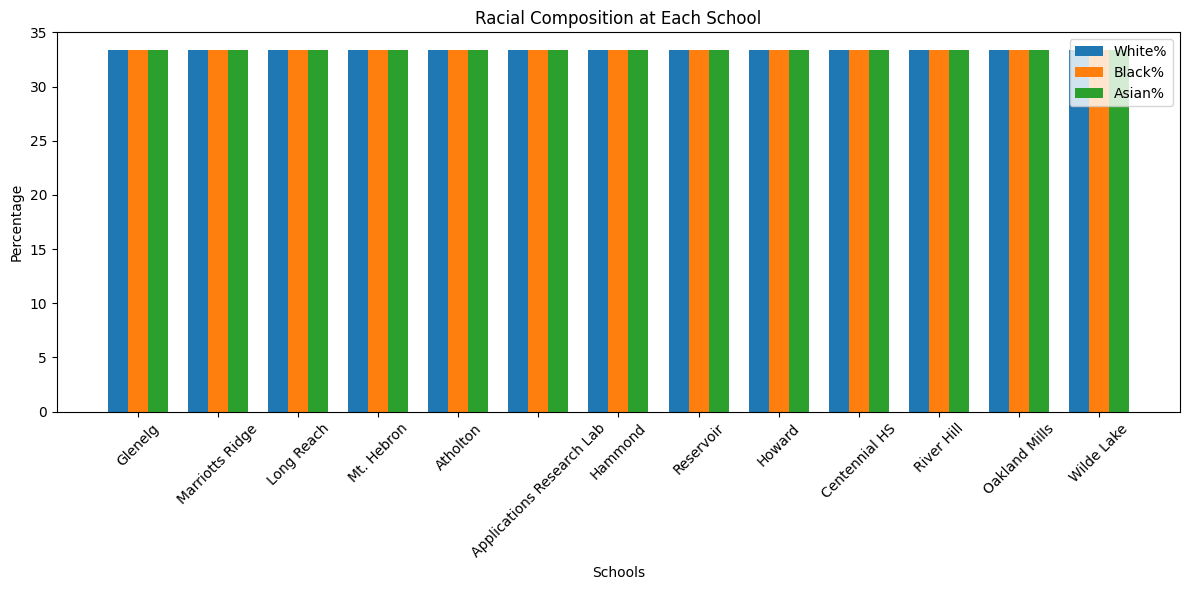

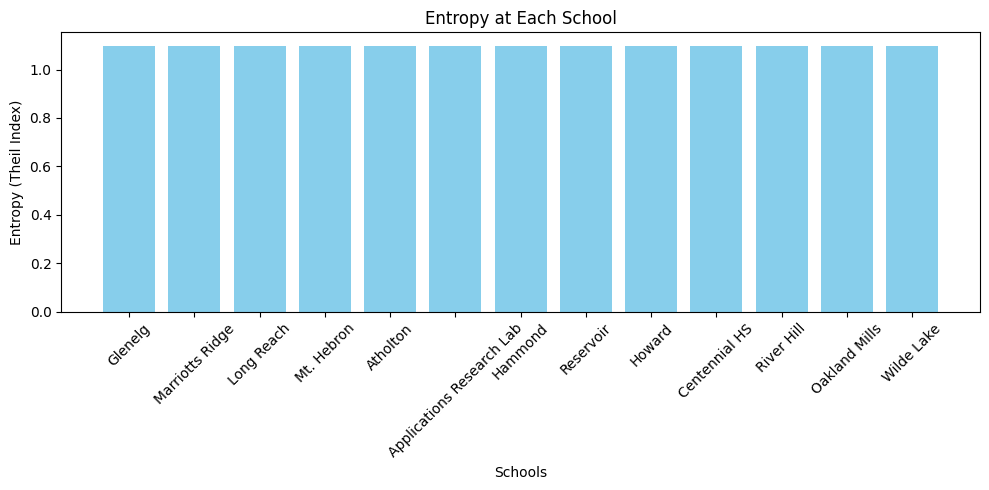

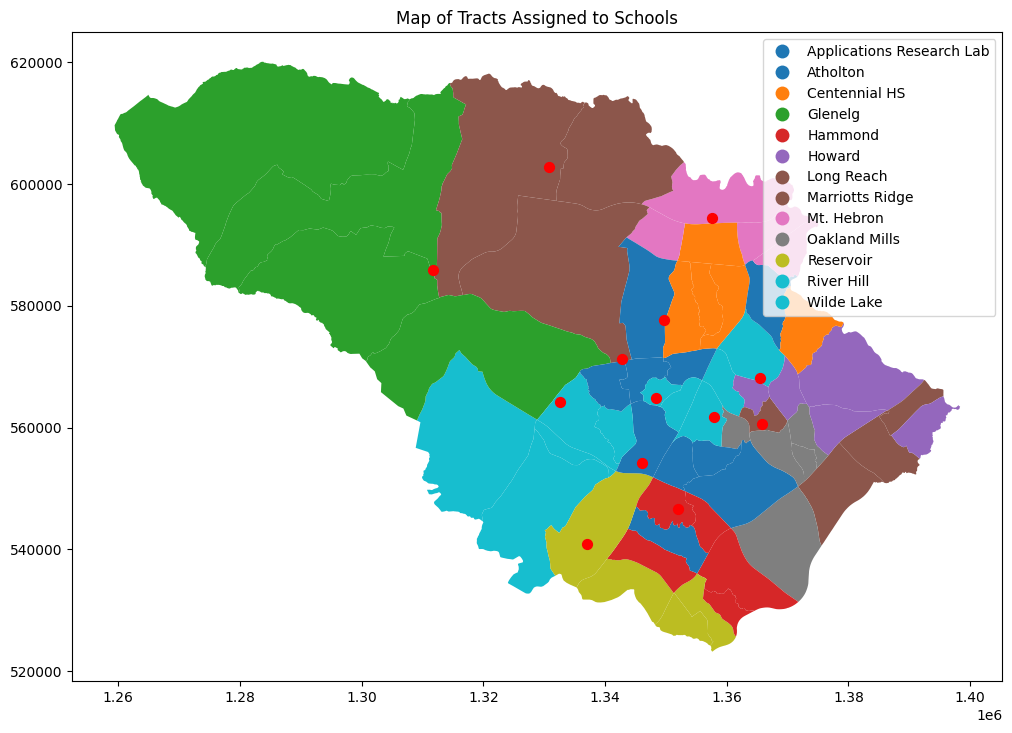

In [41]:
if result is not None:
    # Visualization of the first optimization
    # Plot racial composition of each school
    schools = list(school_compositions.keys())
    white_percents = [school_compositions[school]['White%'] * 100 for school in schools]
    black_percents = [school_compositions[school]['Black%'] * 100 for school in schools]
    asian_percents = [school_compositions[school]['Asian%'] * 100 for school in schools]
    
    x = np.arange(len(schools))
    width = 0.25
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width, white_percents, width, label='White%')
    plt.bar(x, black_percents, width, label='Black%')
    plt.bar(x + width, asian_percents, width, label='Asian%')
    
    plt.xlabel('Schools')
    plt.ylabel('Percentage')
    plt.title('Racial Composition at Each School')
    plt.xticks(x, schools, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot school entropies
    entropies = [school_entropies[school] for school in schools]
    
    plt.figure(figsize=(10, 5))
    plt.bar(schools, entropies, color='skyblue')
    plt.xlabel('Schools')
    plt.ylabel('Entropy (Theil Index)')
    plt.title('Entropy at Each School')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot map
    gdf_results = gpd.GeoDataFrame(df_results, geometry='geometry')
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    gdf_results.plot(column='School', ax=ax, legend=True)
    gdf_schools.plot(ax=ax, color='red', markersize=50)
    plt.title('Map of Tracts Assigned to Schools')
    plt.show()


In [42]:
milp_metrics = compute_metrics(df_results)

print("\nMILP Allocation Metrics:")
print(f"Total Family Cost: {milp_metrics['family_cost']}")
print(f"Total Racial Imbalance: {milp_metrics['racial_imbalance']}")
print(f"Total Compactness Penalty: {milp_metrics['compactness_penalty']}")
print(f"Average Entropy (Theil Index): {milp_metrics['average_entropy']}")
print(f"Total Envy Count: {milp_metrics['envy_count']}")


MILP Allocation Metrics:
Total Family Cost: 4189446867.538505
Total Racial Imbalance: 331803.999823
Total Compactness Penalty: 284577.3654291335
Average Entropy (Theil Index): 1.0986122886681093
Total Envy Count: 23


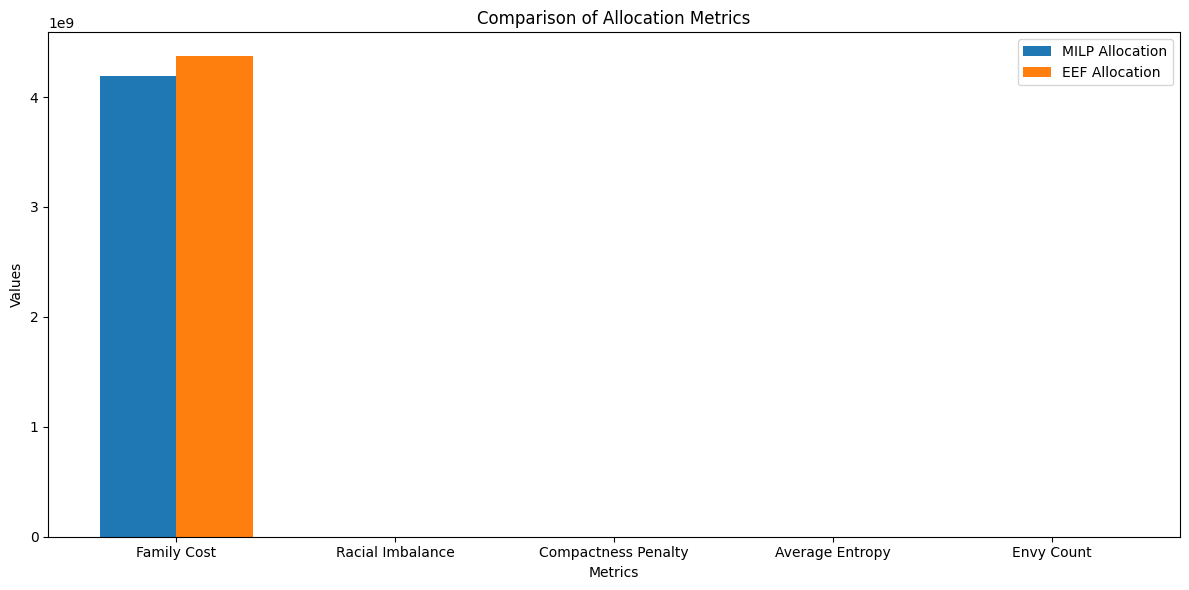

In [43]:
metrics = ['Family Cost', 'Racial Imbalance', 'Compactness Penalty', 'Average Entropy', 'Envy Count']
milp_values = [milp_metrics['family_cost'], milp_metrics['racial_imbalance'],
			   milp_metrics['compactness_penalty'], milp_metrics['average_entropy'], milp_metrics['envy_count']]
eefx_values = [eefx_metrics['family_cost'], eefx_metrics['racial_imbalance'],
			   eefx_metrics['compactness_penalty'], eefx_metrics['average_entropy'], eefx_metrics['envy_count']]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, milp_values, width, label='MILP Allocation')
plt.bar(x + width/2, eefx_values, width, label='EEF Allocation')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Allocation Metrics')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

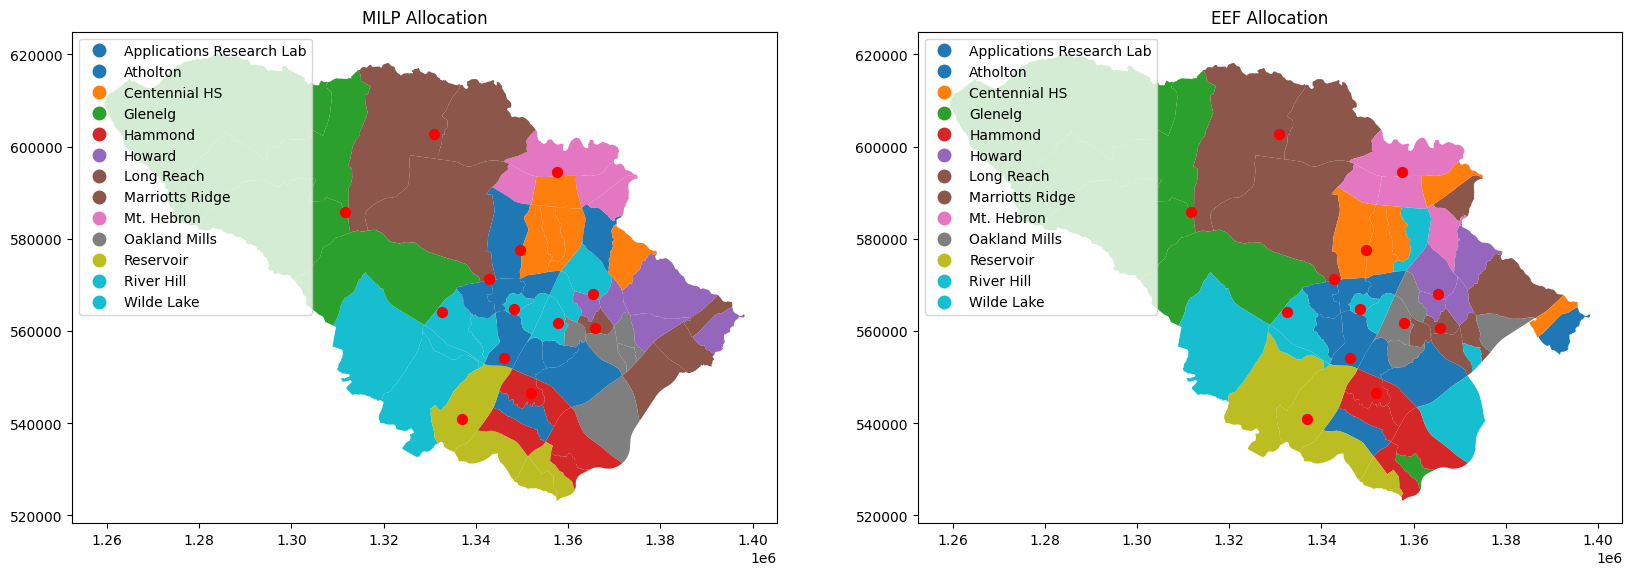

In [44]:
gdf_eefx_results = gpd.GeoDataFrame(df_eefx_results, geometry='geometry')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

gdf_results.plot(column='School', ax=ax[0], legend=True)
gdf_schools.plot(ax=ax[0], color='red', markersize=50)
ax[0].set_title('MILP Allocation')

gdf_eefx_results.plot(column='School', ax=ax[1], legend=True)
gdf_schools.plot(ax=ax[1], color='red', markersize=50)
ax[1].set_title('EEF Allocation')

plt.show()

In [45]:
# Function to compute school compositions and entropies

def compute_school_compositions(df_results):
	school_compositions = {}
	school_entropies = {}
	for school in school_names:
		school_data = df_results[df_results['School'] == school]
		total_population = school_data['Population'].sum()
		white_population = school_data['White'].sum()
		black_population = school_data['Black'].sum()
		asian_population = school_data['Asian'].sum()
		total_race_population = white_population + black_population + asian_population
		if total_race_population == 0:
			continue
		proportions = {
			'White%': white_population / total_race_population,
			'Black%': black_population / total_race_population,
			'Asian%': asian_population / total_race_population
		}
		entropy = -sum([p * np.log(p) if p > 0 else 0 for p in proportions.values()])
		school_compositions[school] = proportions
		school_entropies[school] = entropy
	return school_compositions, school_entropies

In [ ]:
# MILP Allocation

milp_compositions, milp_entropies = compute_school_compositions(df_results)

# EEFX Allocation

eefx_compositions, eefx_entropies = compute_school_compositions(df_eefx_results)

# EEFX with Composite Valuations

eefx_compositions_composite, eefx_entropies_composite = compute_school_compositions(df_eefx_results)

In [47]:
# Print compositions and entropies

print("\nMILP School Racial Compositions and Entropies:")
for school in school_names:
	if school in milp_compositions:
		comp = milp_compositions[school]
		entropy = milp_entropies[school]
		print(f"\nSchool: {school}")
		for race, perc in comp.items():
			print(f"  {race}: {perc*100:.2f}%")
		print(f"  Entropy: {entropy:.4f}")

print("\nEEF Allocation School Racial Compositions and Entropies:")
for school in school_names:
	if school in eefx_compositions:
		comp = eefx_compositions[school]
		entropy = eefx_entropies[school]
		print(f"\nSchool: {school}")
		for race, perc in comp.items():
			print(f"  {race}: {perc*100:.2f}%")
		print(f"  Entropy: {entropy:.4f}")



MILP School Racial Compositions and Entropies:

School: Glenelg
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Marriotts Ridge
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Long Reach
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Mt. Hebron
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Atholton
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Applications Research Lab
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Hammond
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Reservoir
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Howard
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: Centennial HS
  White%: 33.33%
  Black%: 33.33%
  Asian%: 33.33%
  Entropy: 1.0986

School: River Hill
  White%: 33.33%
  Black%: 33.33

4. Grid Search Over Objective Function Weights and Constraint Slacks


### Grid Search With Entropy and Envy

## TO DO:

More Plots of Grid Search Results (Entropy vs. Lambda Choice, Envy vs Lambda Choice, etc.)

Use more data of other districts.
